https://github.com/mwaskom/seaborn/issues/3462

In [ ]:
import warnings

warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")

In [ ]:
!pip install lightning

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import lightning.pytorch as pl

from torch.utils.data import TensorDataset, DataLoader

from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,MinMaxScaler, OneHotEncoder

In [ ]:
class InsuranceDataModule(pl.LightningDataModule):

    def __init__(self, batch_size: int = 8):
        super().__init__()

        self.batch_size = batch_size

    def prepare_data(self):
        self.insurance_data = pd.read_csv("./insurance.csv")

    def setup(self, stage = None):

        X = self.insurance_data.drop(columns = ["charges"])
        y = self.insurance_data["charges"]

        if stage == "fit" or stage is None:
            X_train, X_val, y_train, y_val = \
                train_test_split(X, y, test_size = 0.2, random_state = 123)

            categorical_features = ["sex", "smoker", "region"]

            categorical_transformer = OneHotEncoder(
                handle_unknown = "ignore", drop = "first", sparse_output = False
            )

            preprocessor = ColumnTransformer(
                transformers = [("cat_tr", categorical_transformer, categorical_features)],
                remainder = "passthrough"
            )

            X_train = preprocessor.fit_transform(X_train)
            X_val = preprocessor.transform(X_val)

            y_train = y_train.to_numpy()
            y_val = y_val.to_numpy()

            ## Standard scaling features
            stdscaler = StandardScaler()
            X_train = stdscaler.fit_transform(X_train)
            X_val = stdscaler.transform(X_val)

            ## Min max scaling targets
            min_max_scaler = MinMaxScaler()
            y_train = min_max_scaler.fit_transform(y_train.reshape(-1, 1))
            y_val = min_max_scaler.transform(y_val.reshape(-1, 1))

            ## Convert to tensors
            self.train_inputs = torch.from_numpy(X_train).float()
            self.train_targets = torch.from_numpy(y_train.reshape(-1, 1)).float()
            self.val_inputs = torch.from_numpy(X_val).float()
            self.val_targets = torch.from_numpy(y_val.reshape(-1, 1)).float()

    def train_dataloader(self):
        train_dataset = TensorDataset(
            self.train_inputs, self.train_targets
        )
        train_loader = DataLoader(
            dataset = train_dataset,
            batch_size = self.batch_size,
            shuffle = True,
            num_workers = 4
        )

        return train_loader

    def val_dataloader(self):
        validation_dataset = TensorDataset(
            self.val_inputs, self.val_targets
        )
        validation_loader = DataLoader(
            dataset = validation_dataset,
            batch_size = self.batch_size,
            num_workers = 4
        )

        return validation_loader

Datamodule is instantiated

In [ ]:
insurance_dm = InsuranceDataModule()

Both prepare_data and setup are invoked to check the preprocessed data

In [ ]:
insurance_dm.prepare_data()
insurance_dm.setup()

Both training and validation dataloaders are checked. Note that batch size is set as 5 as default

In [ ]:
train_dl = insurance_dm.train_dataloader()

next(iter(train_dl))

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[tensor([[-1.0113, -0.5000, -0.5809, -0.6213, -0.5478, -0.5759,  0.0697, -0.8865],
         [ 0.9888, -0.5000, -0.5809,  1.6095, -0.5478,  0.0621,  1.8354, -0.8865],
         [ 0.9888,  2.0000, -0.5809,  1.6095, -0.5478,  0.5582, -0.8700, -0.0674],
         [-1.0113, -0.5000,  1.7213, -0.6213, -0.5478,  0.2747,  0.6538, -0.0674],
         [-1.0113, -0.5000, -0.5809,  1.6095, -0.5478, -1.4973, -1.0894, -0.0674],
         [ 0.9888, -0.5000, -0.5809, -0.6213,  1.8254,  1.1962,  0.9064,  1.5709],
         [-1.0113, -0.5000, -0.5809,  1.6095, -0.5478, -0.7885, -0.6872,  0.7517],
         [-1.0113, -0.5000, -0.5809, -0.6213,  1.8254,  0.6291, -0.2900, -0.8865]]),
 tensor([[0.0525],
         [0.0702],
         [0.3393],
         [0.1075],
         [0.0176],
         [0.1829],
         [0.0524],
         [0.1164]])]

In [ ]:
val_dl = insurance_dm.val_dataloader()

next(iter(val_dl))

[tensor([[-1.0113, -0.5000, -0.5809,  1.6095, -0.5478,  0.7000,  1.9999,  0.7517],
         [ 0.9888, -0.5000, -0.5809, -0.6213, -0.5478, -0.5050,  1.1117, -0.0674],
         [-1.0113,  2.0000, -0.5809, -0.6213,  1.8254, -0.8594,  0.1254, -0.8865],
         [ 0.9888, -0.5000,  1.7213, -0.6213, -0.5478, -0.2923, -1.0827, -0.0674],
         [ 0.9888, -0.5000, -0.5809,  1.6095, -0.5478,  1.4797, -0.8152, -0.8865],
         [-1.0113, -0.5000, -0.5809,  1.6095, -0.5478,  0.7709, -0.4130,  1.5709],
         [ 0.9888, -0.5000, -0.5809, -0.6213, -0.5478, -0.8594, -1.9510,  1.5709],
         [-1.0113, -0.5000, -0.5809, -0.6213,  1.8254, -0.4341, -2.0183, -0.0674]]),
 tensor([[0.1412],
         [0.0577],
         [0.5485],
         [0.0651],
         [0.1793],
         [0.1559],
         [0.0603],
         [0.0593]])]

https://lightning.ai/docs/pytorch/stable/common/lightning_module.html

In [ ]:
class LitRegressionModule(pl.LightningModule):

    def __init__(self, num_features, learning_rate = 0.01):
        super().__init__()

        self.layer_1 = nn.Linear(num_features, 16)
        self.layer_2 = nn.Linear(16, 32)
        self.layer_3 = nn.Linear(32, 16)
        self.layer_out = nn.Linear(16, 1)

        self.relu = nn.ReLU()
        self.save_hyperparameters()

    def forward(self, inputs):

        x = self.relu(self.layer_1(inputs))
        x = self.relu(self.layer_2(x))
        x = self.relu(self.layer_3(x))
        x = self.layer_out(x)

        return (x)

    def training_step(self, batch, batch_idx):
        x, y = batch

        output = self.forward(x)

        loss_fn = nn.MSELoss(reduction = "mean")
        loss = loss_fn(output, y)

        self.log("train_loss", loss, prog_bar = True)

        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch

        output = self.forward(x)
        loss_fn = nn.MSELoss(reduction = "mean")
        loss = loss_fn(output, y)

        self.log(f"val_loss", loss, on_epoch = True, prog_bar = True)

    def predict_step(self, batch, batch_idx, dataloader_idx = 0):
        x, y = batch

        return self(x)

    def configure_optimizers(self):
        return optim.SGD(self.parameters(), lr = self.hparams.learning_rate)

We can generate output from Lightning Module in the same way as Pytorch Module

In [ ]:
model = LitRegressionModule(num_features = 8)

print(model)

LitRegressionModule(
  (layer_1): Linear(in_features=8, out_features=16, bias=True)
  (layer_2): Linear(in_features=16, out_features=32, bias=True)
  (layer_3): Linear(in_features=32, out_features=16, bias=True)
  (layer_out): Linear(in_features=16, out_features=1, bias=True)
  (relu): ReLU()
)


## TODO recording:

Please scroll and show the model output carefully

In [ ]:
from pytorch_lightning.loggers import CSVLogger

insurance_dm = InsuranceDataModule()

logger = CSVLogger("logs", name = "Pytorch_lightning_training")

trainer = pl.Trainer(max_epochs = 50, logger = logger)

trainer.fit(model, datamodule = insurance_dm)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: 
  | Name      | Type   | Params | Mode 
---------------------------------------------
0 | layer_1   | Linear | 144    | train
1 | layer_2   | Linear | 544    | train
2 | layer_3   | Linear | 528    | train
3 | layer_out | Linear | 17     | train
4 | relu      | ReLU   | 0      | train
---------------------------------------------
1.2 K     Trainable params
0         Non-trainable params
1.2 K     Total params
0.005     Total estimated model params size (MB)
INFO:lightning.pytorch.callbacks.model_summary:
  | Name      | Type   | Params | Mode 
---------------------------------------------
0 | layer_1   | Linear | 144    | train
1 | layer_2   | Linear | 544    | train
2 | layer_3   | Linear | 528    | train
3 | layer_out | Linear | 17     | tra

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.


Predictions obtained on validation dataloader.Note:We can predict on test dataloader if it is defined

In [ ]:
predictions = trainer.predict(model = model, dataloaders = insurance_dm.val_dataloader())

predictions

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Predicting: |          | 0/? [00:00<?, ?it/s]

[tensor([[0.2107],
         [0.1206],
         [0.4127],
         [0.0944],
         [0.1508],
         [0.1686],
         [0.1067],
         [0.0922]]),
 tensor([[0.0332],
         [0.0972],
         [0.1150],
         [0.1830],
         [0.2079],
         [0.4231],
         [0.1878],
         [0.4492]]),
 tensor([[0.2488],
         [0.0606],
         [0.5648],
         [0.6623],
         [0.4422],
         [0.9003],
         [0.0791],
         [0.1260]]),
 tensor([[0.0797],
         [0.1091],
         [0.2332],
         [0.1152],
         [0.1996],
         [0.0483],
         [0.1610],
         [0.2216]]),
 tensor([[0.1103],
         [0.0848],
         [0.0427],
         [0.1347],
         [0.2698],
         [0.0674],
         [0.1557],
         [0.1801]]),
 tensor([[0.1068],
         [0.0568],
         [0.0708],
         [0.3748],
         [0.1399],
         [0.0249],
         [0.1605],
         [0.1194]]),
 tensor([[0.1870],
         [0.1100],
         [0.1226],
         [0.1748],


Predictions are stacked

In [ ]:
y_pred_stacked = torch.cat(predictions)

y_pred_stacked[:10]

tensor([[0.2107],
        [0.1206],
        [0.4127],
        [0.0944],
        [0.1508],
        [0.1686],
        [0.1067],
        [0.0922],
        [0.0332],
        [0.0972]])

Labels are stacked

In [ ]:
labels = []

for data, label in insurance_dm.val_dataloader():
    labels.extend(label)

In [ ]:
y_true = torch.stack(labels)

y_true[:10]

tensor([[0.1412],
        [0.0577],
        [0.5485],
        [0.0651],
        [0.1793],
        [0.1559],
        [0.0603],
        [0.0593],
        [0.0090],
        [0.1340]])

Performance are checked same as earlier

In [ ]:
from torchmetrics.regression import R2Score
from torchmetrics.regression import MeanSquaredError

MSE = MeanSquaredError()
r2score = R2Score()

print("Mean Squared Error :", round(MSE(y_pred_stacked, y_true).item(), 3))
print("R^2 :",round(r2score(y_pred_stacked, y_true).item(), 3))

Mean Squared Error : 0.005
R^2 : 0.868


Logged CSV can be loaded from the 'Pytorch lightning training' (which is the experiment name defined in Logger folder) inside logs folder

In [ ]:
metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")

metrics.head(10)

,epoch,step,train_loss,val_loss
0,0,49,0.028965,NaN
1,0,99,0.008881,NaN
2,0,133,NaN,0.033258
3,1,149,0.046467,NaN
4,1,199,0.028545,NaN
5,1,249,0.058550,NaN
6,1,267,NaN,0.029541
7,2,299,0.011748,NaN
8,2,349,0.005460,NaN
9,2,399,0.026636,NaN


In [ ]:
metrics.tail(10)

,epoch,step,train_loss,val_loss
174,47,6399,0.000620,NaN
175,47,6431,NaN,0.005434
176,48,6449,0.006793,NaN
177,48,6499,0.004653,NaN
178,48,6549,0.002026,NaN
179,48,6565,NaN,0.005386
180,49,6599,0.001372,NaN
181,49,6649,0.034578,NaN
182,49,6699,0.002235,NaN
183,49,6699,NaN,0.005339


Obtaining visualisation for Loss vs epoch. Training loss is logged at every fifty steps and validation loss at the end of epoch

,train_loss,val_loss
epoch,,
0,0.028965,NaN
0,0.008881,NaN
0,NaN,0.033258
1,0.046467,NaN
1,0.028545,NaN
1,0.058550,NaN
1,NaN,0.029541
2,0.011748,NaN
2,0.005460,NaN


<Axes: xlabel='epoch'>

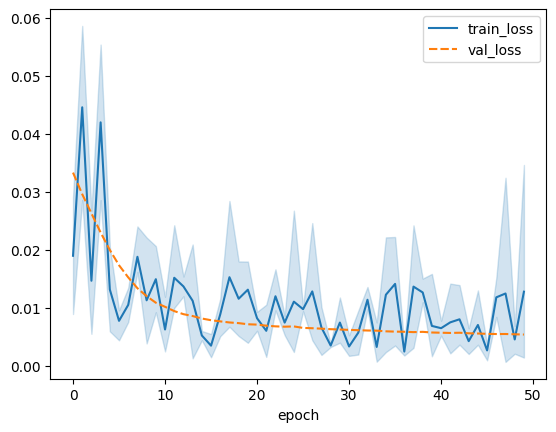

In [ ]:
del metrics["step"]

# Set the epoch column as the index, for easier plotting
metrics.set_index("epoch", inplace = True)

# Display the first few rows of the metrics table, excluding any columns with all NaN values
display(metrics.dropna(axis = 1, how = "all").head(10))

# Create a line plot of the training metrics using Seaborn
sns.lineplot(data = metrics)